
Best Individual: (((8.9893629948264 sub x) sub sqrt(((8.9893629948264 sub x) sub x))) div (5.421629579590618 div ((((((8.9893629948264 sub x) sub sqrt((8.9893629948264 sub x))) sub sqrt((8.9893629948264 sub ((7.608266506642838 add 5.647124319582009) sub x)))) div (5.421629579590618 div (((5.421629579590618 sub x) sub ((x add sin(7.608266506642838)) add ((8.9893629948264 sub sqrt(((7.608266506642838 add ((5.421629579590618 sub x) sub ((x add sin(x)) add ((8.9893629948264 sub sqrt(((7.608266506642838 add ((((8.9893629948264 sub 5.421629579590618) sub ((x add sin(7.608266506642838)) add ((8.9893629948264 sub sqrt((x div (((8.9893629948264 sub x) sub sqrt(((8.9893629948264 sub x) sub x))) div (5.421629579590618 div ((((((8.9893629948264 sub x) sub sqrt((8.9893629948264 sub x))) sub sqrt((8.9893629948264 sub ((7.608266506642838 add 5.647124319582009) sub x)))) div (5.421629579590618 div (((5.421629579590618 sub x) sub ((x add sin(x)) add ((8.9893629948264 sub sqrt(((7.608266506642838 add (

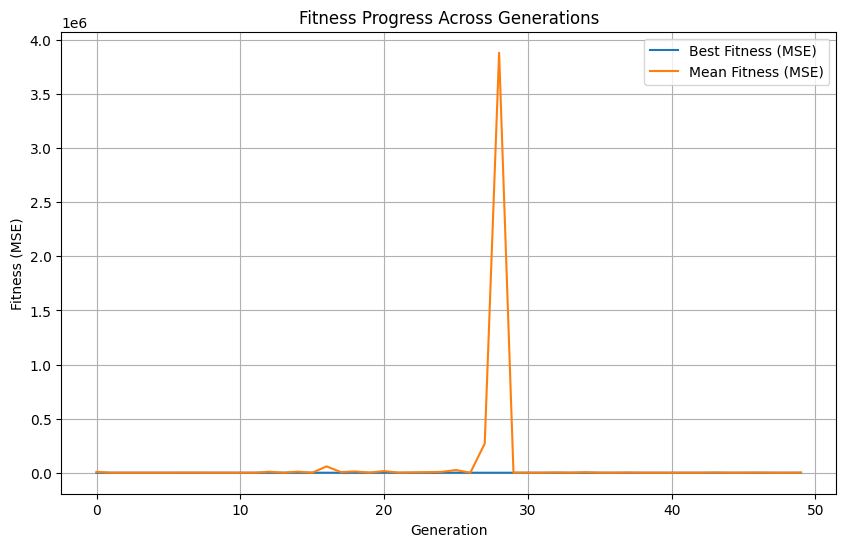

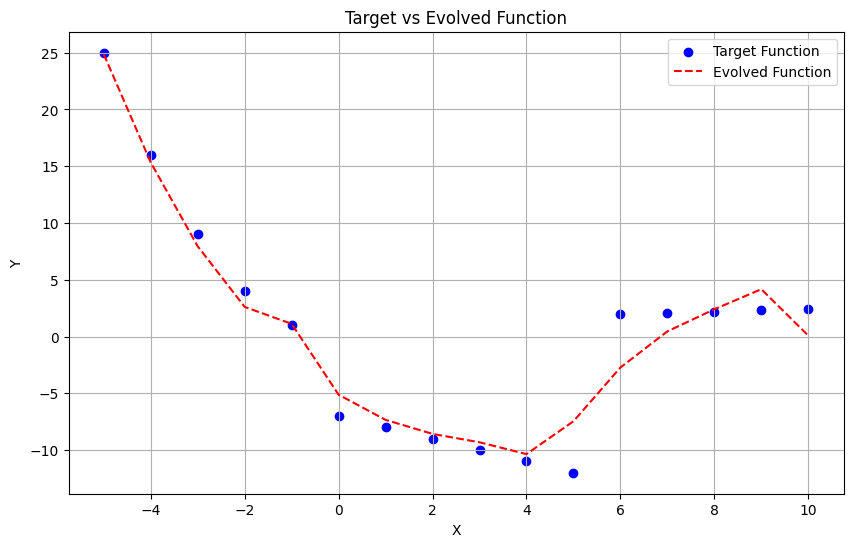

In [1]:
import math
import random
import copy
import statistics
import matplotlib.pyplot as plt

# ----------------- Configuration -----------------
POP_SIZE = 100
MAX_DEPTH = 5
GENERATIONS = 50
MUTATION_RATE = 0.2
NUM_CONSTANTS = 5  # Random constants for the terminal set

# ----------------- Training Data (Clauses 1 & 2) -----------------
# Define target function with discontinuities and operators not in GP
def target_function(x):
    c1, c2 = 0, 5  # Define discontinuity points
    if x < c1:
        return x**2  # Power operator
    elif c1 <= x <= c2:
        return -x - 7
    else:
        return math.log(x + 1) if x > 0 else 0  # Logarithm operator (excluded from GP)

# Training points: discrete integers from -5 to 10
TRAIN_X = list(range(-5, 11))
TRAIN_Y = [target_function(x) for x in TRAIN_X]

# ----------------- Function and Terminal Sets -----------------
FUNCTION_SET = [
    {'name': 'add', 'arity': 2, 'func': lambda a, b: a + b},
    {'name': 'sub', 'arity': 2, 'func': lambda a, b: a - b},
    {'name': 'mul', 'arity': 2, 'func': lambda a, b: a * b},
    {'name': 'div', 'arity': 2, 'func': lambda a, b: a / b if b != 0 else 1.0},
    {'name': 'sin', 'arity': 1, 'func': lambda a: math.sin(a)},
    {'name': 'sqrt', 'arity': 1, 'func': lambda a: math.sqrt(abs(a))}
]

TERMINALS = ['x'] + [random.uniform(-10, 10) for _ in range(NUM_CONSTANTS)]

# ----------------- Node Class -----------------
class Node:
    def __init__(self, is_function, value, children=None):
        self.is_function = is_function
        self.value = value
        self.children = children if children else []

    def __str__(self):
        if self.is_function:
            if self.value['arity'] == 1:
                return f"{self.value['name']}({self.children[0]})"
            else:
                return f"({self.children[0]} {self.value['name']} {self.children[1]})"
        else:
            return str(self.value)

# ----------------- Tree Generation -----------------
def generate_random_tree(max_depth, function_set, terminals):
    if max_depth == 0:
        return Node(is_function=False, value=random.choice(terminals))
    else:
        if random.random() < 0.5:
            func = random.choice(function_set)
            if func['arity'] == 1:
                return Node(is_function=True, value=func, children=[
                    generate_random_tree(max_depth - 1, function_set, terminals)
                ])
            else:
                return Node(is_function=True, value=func, children=[
                    generate_random_tree(max_depth - 1, function_set, terminals),
                    generate_random_tree(max_depth - 1, function_set, terminals)
                ])
        else:
            return Node(is_function=False, value=random.choice(terminals))

# ----------------- Evaluate Expression Trees -----------------
def evaluate_tree(node, x_val):
    if node.is_function:
        func = node.value
        if func['arity'] == 1:
            return func['func'](evaluate_tree(node.children[0], x_val))
        else:
            return func['func'](
                evaluate_tree(node.children[0], x_val),
                evaluate_tree(node.children[1], x_val)
            )
    else:
        return x_val if node.value == 'x' else float(node.value)

# ----------------- Fitness Function -----------------
def fitness(individual, train_x, train_y):
    mse = sum((evaluate_tree(individual, x) - y)**2 for x, y in zip(train_x, train_y))
    return mse / len(train_x)

# ----------------- Genetic Operators -----------------
def tournament_selection(population, fitnesses, k=5):
    selected = random.sample(list(zip(population, fitnesses)), k)
    return min(selected, key=lambda x: x[1])[0]

def get_all_nodes(node):
    nodes = [node]
    for child in node.children:
        nodes.extend(get_all_nodes(child))
    return nodes

def replace_subtree(original, target, replacement):
    if original is target:
        return replacement
    for i, child in enumerate(original.children):
        if child is target:
            original.children[i] = replacement
            return original
        else:
            replace_subtree(child, target, replacement)
    return original

def crossover(parent1, parent2):
    p1 = copy.deepcopy(parent1)
    p2 = copy.deepcopy(parent2)
    subtree1 = random.choice(get_all_nodes(p1))
    subtree2 = random.choice(get_all_nodes(p2))
    replace_subtree(p1, subtree1, copy.deepcopy(subtree2))
    return p1

def mutation(individual, function_set, terminals, max_depth):
    mutant = copy.deepcopy(individual)
    subtree_to_replace = random.choice(get_all_nodes(mutant))
    new_subtree = generate_random_tree(max_depth, function_set, terminals)
    replace_subtree(mutant, subtree_to_replace, new_subtree)
    return mutant

# ----------------- Main Evolutionary Loop -----------------
population = [generate_random_tree(MAX_DEPTH, FUNCTION_SET, TERMINALS) for _ in range(POP_SIZE)]
generation_best_fitness = []
generation_mean_fitness = []

for gen in range(GENERATIONS):
    fitnesses = [fitness(ind, TRAIN_X, TRAIN_Y) for ind in population]
    best_idx = fitnesses.index(min(fitnesses))
    best_individual = population[best_idx]
    generation_best_fitness.append(fitnesses[best_idx])
    generation_mean_fitness.append(sum(fitnesses) / len(fitnesses))
    #print(f"Gen {gen}: Best Fitness = {fitnesses[best_idx]}, Best Individual: {best_individual}")

    new_population = []
    while len(new_population) < POP_SIZE:
        p1 = tournament_selection(population, fitnesses)
        p2 = tournament_selection(population, fitnesses)
        child = crossover(p1, p2)
        if random.random() < MUTATION_RATE:
            child = mutation(child, FUNCTION_SET, TERMINALS, MAX_DEPTH)
        new_population.append(child)

    population = new_population

def pretty_print(node):
    """Convert a tree node into a human-readable mathematical expression string."""
    if node.is_function:
        fname = node.value['name']
        if fname == 'add':
            return f"({pretty_print(node.children[0])} + {pretty_print(node.children[1])})"
        elif fname == 'sub':
            return f"({pretty_print(node.children[0])} - {pretty_print(node.children[1])})"
        elif fname == 'mul':
            return f"({pretty_print(node.children[0])} * {pretty_print(node.children[1])})"
        elif fname == 'div':
            return f"({pretty_print(node.children[0])} / {pretty_print(node.children[1])})"
        elif fname == 'pow':
            return f"({pretty_print(node.children[0])} ^ {pretty_print(node.children[1])})"
        elif fname == 'sin':
            return f"sin({pretty_print(node.children[0])})"
        elif fname == 'sqrt':
            return f"sqrt({pretty_print(node.children[0])})"
        else:
            return f"{fname}({', '.join(pretty_print(child) for child in node.children)})"
    else:
        return str(node.value)  # For variables ('x') or constants


# ----------------- Best Solution -----------------
best_idx = fitnesses.index(min(fitnesses))
best_tree = population[best_idx]
best_fitness = fitnesses[best_idx]

print(f"\nBest Individual: {best_tree}")
print(f"Best Fitness (MSE): {best_fitness}")

# Calculate MSE and Accuracy Percentage
variance_of_true_outputs = statistics.pvariance(TRAIN_Y)
best_fitness = min(fitnesses)  # The lowest MSE in the current generation
accuracy_percentage = (1 - (best_fitness / variance_of_true_outputs)) * 100

print("\nFinal Best Individual (Mathematical Form):")
print(pretty_print(best_tree))

print(f"\nFinal Best Fitness (MSE): {best_fitness:.4f}")
print(f"Variance of True Outputs: {variance_of_true_outputs:.4f}")
print(f"Accuracy Percentage: {accuracy_percentage:.2f}%")


# ----------------- Plot Results (Clauses 4 & 6) -----------------
# Plot MSE progress
plt.figure(figsize=(10, 6))
plt.plot(range(GENERATIONS), generation_best_fitness, label="Best Fitness (MSE)")
plt.plot(range(GENERATIONS), generation_mean_fitness, label="Mean Fitness (MSE)")
plt.title("Fitness Progress Across Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness (MSE)")
plt.legend()
plt.grid()
plt.show()

# Compare Target and Evolved Function
plt.figure(figsize=(10, 6))
plt.scatter(TRAIN_X, TRAIN_Y, label="Target Function", color="blue")
estimated_y = [evaluate_tree(best_tree, x) for x in TRAIN_X]
plt.plot(TRAIN_X, estimated_y, label="Evolved Function", linestyle="--", color="red")
plt.title("Target vs Evolved Function")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()
